### Speed of NYC Permit Approval for Green Retrofits of Small Buildings
#### Data Exploration

Setup

In [6]:
from glob import glob
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import geopandas as gpd

Define Socrata API handler to page through JSON data

In [2]:
def get_resource(resource, query='', dates=[], limit=1000, progress=False):
    headers = {'X-App-Token': 'b0nu5h6f5RSJRNPajPuuCf7wo'}
    result = []
    offset = 0
    while offset >= 0:
        url = f'https://data.cityofnewyork.us/resource/{resource}.json?$limit={limit}&$offset={offset}&$order=:id'
        if query != '': #can't use requests params bc of possible $ char
            url += f'&{query}'
        if (progress):
            print(url)
        json = requests.get(url, headers=headers).json()
        if 'error' in json:
            print(json['message'])
            return
        else:
            df = pd.DataFrame(json)
            if len(df):
                if len(dates):
                    df[dates] = df[dates].apply(pd.to_datetime, errors='coerce')
                result.append(df)
                offset += limit
            else:
                offset = -1

    result = pd.concat(result).reset_index() if len(result) else pd.DataFrame()
    print(f'Retreived {len(result)} records')
    return result

Get [job application](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2?category=Housing-Development&view_name=DOB-Job-Application-Filings) A2-3 filings (non occupancy/egress alterations)

In [3]:
# resource = 'ic3t-wcy2'
# query = "$where=job_type IN ('A2', 'A3') AND job_status IN ('P', 'Q', 'R', 'X') AND job_description != ''"
# dates = ['latest_action_date', 'assigned', 'approved', 'fully_permitted']
# job = get_resource(resource, query, dates)

Retreived 1285131 records


In [4]:
# job.to_feather('job.feather')

In [7]:
job = pd.read_feather('job.feather')
job.columns

Index(['index', 'job__', 'doc__', 'borough', 'house__', 'street_name', 'block',
       'lot', 'bin__', 'job_type', 'job_status', 'job_status_descrp',
       'latest_action_date', 'building_type', 'community___board',
       'landmarked', 'adult_estab', 'pc_filed', 'plumbing', 'mechanical',
       'applicant_s_first_name', 'applicant_s_last_name',
       'applicant_professional_title', 'applicant_license__',
       'professional_cert', 'pre__filing_date', 'paid', 'fully_paid',
       'initial_cost', 'total_est__fee', 'fee_status', 'existing_zoning_sqft',
       'proposed_zoning_sqft', 'enlargement_sq_footage', 'street_frontage',
       'existingno_of_stories', 'proposed_no_of_stories', 'existing_height',
       'proposed_height', 'proposed_dwelling_units', 'site_fill', 'owner_type',
       'non_profit', 'owner_s_first_name', 'owner_s_last_name',
       'owner_s_business_name', 'owner_s_house_number',
       'owner_shouse_street_name', 'city_', 'state', 'zip', 'owner_sphone__',
       'j

Tag jobs as solar. May need to make this more sophisticated in the future

In [8]:
job['solar_jobs'] = job['job_description'].str.lower().apply(lambda x: 'solar' in x)
_ = [print(desc) for desc in job.loc[job['solar_jobs'], 'job_description'][:10]]

INSTALLATION OF ROOF MOUNTED SOLAR. NO CHANGE IN USE, EGRESS, OR OCCUPANCY.
ROOFTOP SOLAR PANEL INSTALLATION
INSTALLATION OF SOLAR PANELS ON EXISTING ROOF STRUCTURE. NO CHANGE IN EGRESS, USE, OR OCCUPANCY
INSTALLATION OF A ROOFTOP RAILLESS SOLAR PV PANEL SYSTEM
FILLING HEREWITH TAX ABATEMENT APPLICATION FOR INSTALLATION OF ROOF MOUNTED SOLAR PANELS. NO CHANGE IN USE, EGRESS OR OCCUPANCY.
INSTALLATION OF A ROOFTOP RAILLESS SOLAR PV PANEL SYSTEM
INSTALLATION OF SOLAR PANELS ON ROOFTOP. NO CHANGE IN USE, EGRESS, OR OCCUPANCY.
INSTALLATION OF SOLAR PANELS ON EXISTING ROOF. NO CHANGE IN USE, OCCUPANCY,  OR EGRESS. NO CHANGE IN BULK.
INSTALLATION OF SOLAR PANELS ON EXISTING ROOF. NO CHANGE IN USE, OCCUPANCY,  OR EGRESS. NO CHANGE IN BULK.
INSTALLATION OF SOLAR SYSTEM AS PER PLANS.NO CHANGE IN USE,EGRESS, OR OCCUPANCY


In [9]:
job_bin = job.groupby('bin__').agg({'approved': 'min', 'solar_jobs': 'sum'}).reset_index() # aggregate to BIN level (final aggregation)

<AxesSubplot:ylabel='Frequency'>

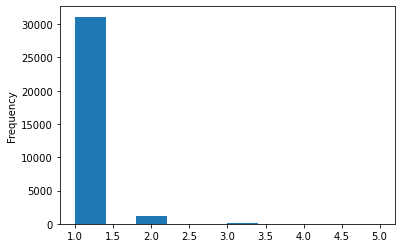

In [88]:
job_bin['solar_jobs'][job_bin['solar_jobs'] > 0].plot.hist()

Load [PLUTO](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page) data and keep only relevant variables

In [10]:
pluto = pd.read_csv('pluto_21v1.csv', low_memory=False)
pluto.columns

Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healthcenterdistrict',
       'healtharea', 'sanitboro', 'sanitdistrict', 'sanitsub', 'address',
       'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1',
       'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone',
       'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername',
       'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource',
       'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode',
       'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot',
       'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl',
       'condono', 'tract2010', 'xcoo

In [42]:
vals = ['assesstot', 'exempttot', 'numfloors', 'bldgarea', 'comarea', 'resarea']  #pluto is by BBL, spread these values across each BIN
cols = ['bbl', 'latitude', 'longitude', 'numbldgs', 'yearbuilt', 'landuse', *vals]

pluto_sub = pluto.loc[(pluto['numbldgs'].between(1, 2)) & (pluto['yearbuilt'] != 0) & (pluto['landuse'] < 9) & (pluto['landmark'].isnull()) & (~pluto['latitude'].isnull()), cols]
pluto_sub[vals] = pluto_sub[vals].apply(lambda x: x / pluto_sub['numbldgs'])

Load [DOB building](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh/data) data, with sky view factor (a measure of sunlight availability) calculated in QGIS using digital elevation model from 2017 [NYC Topobathymetric](https://gis.ny.gov/elevation/NYC-topobathymetric-DEM.htm) LiDAR data

In [4]:
build = pd.concat([pd.read_csv(file, low_memory=False) for file in glob('stats/*')])
build.head()

,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,shape_area,shape_len,_count,_sum,_mean
0,3.000410e+09,3000095.0,1900.0,314181.0,2100.0,Other (Man,33.0,63.00,2017/08/22,00:00:00.000,Constructed,3.000410e+09,NaN,41010.405199,893.931165,41015.0,30535.053206,0.744485
1,3.000430e+09,3255594.0,1841.0,135467.0,2100.0,Photogramm,34.0,33.75,2020/01/28,00:00:00.000,Constructed,3.000430e+09,NaN,892.654266,120.752952,894.0,657.804927,0.735800
2,3.001820e+09,3428624.0,2018.0,1288560.0,2100.0,Other (Man,30.0,NaN,2019/11/26,00:00:00.000,Constructed,3.001820e+09,NaN,3135.289427,225.818806,3135.0,1029.700555,0.328453
3,3.003960e+09,3006349.0,1899.0,34866.0,2100.0,Photogramm,34.0,35.74,2017/08/22,00:00:00.000,Constructed,3.003960e+09,NaN,834.392803,136.064926,836.0,594.515018,0.711142
4,3.001340e+09,3420828.0,2013.0,1263693.0,2100.0,Other (Man,25.0,396.00,2017/08/22,00:00:00.000,Constructed,3.001340e+09,NaN,15285.423660,538.032966,15277.0,6430.407424,0.420921


In [5]:
build_bin = build.groupby('bin')[['mpluto_bbl', 'shape_area', '_mean']].min().reset_index() # batched by ZIP, some contain same BIN
build_bin.rename(columns={'_mean': 'svf'}, inplace=True)

Merge datasets at the BIN level (PLUTO has BBL values spread across BINs)

In [90]:
job_bin['bin'] = job_bin['bin__'].astype(float)

full = build_bin.merge(pluto_sub, left_on='mpluto_bbl', right_on='bbl').merge(job_bin, 'left', 'bin')

full['some_solar'] = full['solar_jobs'] > 0
full.loc[~full['some_solar'], 'approved'] = pd.NaT # only keep permit approval dates relevant to solar installs
full.drop(['bin__', 'mpluto_bbl', 'bbl', 'solar_jobs'], axis=1, inplace=True)
full

,bin,shape_area,svf,latitude,longitude,numbldgs,yearbuilt,landuse,assesstot,exempttot,numfloors,bldgarea,comarea,resarea,approved,some_solar
0,1290422.0,1393.438325,0.684443,40.665415,-73.888027,1.0,2016.0,2.0,385650.0,383877.0,4.00,5492.0,0.0,5205.0,NaT,False
1,3000002.0,17683.475106,0.769877,40.704620,-73.987059,1.0,1898.0,5.0,17318250.0,0.0,10.00,170493.0,163894.0,0.0,NaT,False
2,3000007.0,8192.772710,0.730845,40.704110,-73.989303,1.0,1988.0,8.0,371250.0,371250.0,1.00,9585.0,9585.0,0.0,NaT,False
3,3000010.0,43459.105586,0.729904,40.704102,-73.987070,1.0,1909.0,5.0,30760650.0,2922885.0,11.00,500000.0,500000.0,0.0,NaT,False
4,3000011.0,19246.260335,0.827548,40.703975,-73.986197,1.0,1977.0,5.0,1474200.0,0.0,1.00,21735.0,21735.0,0.0,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315632,3428902.0,3246.916546,0.711528,40.731988,-73.959329,1.0,2017.0,4.0,601650.0,0.0,7.00,8982.0,602.0,8380.0,NaT,False
315633,3428938.0,25214.834473,0.759847,40.736426,-73.959568,1.0,2018.0,4.0,36553950.0,0.0,39.00,448412.0,70020.0,378392.0,NaT,False
315634,3435471.0,1626.362731,0.571410,40.732314,-73.952415,1.0,2012.0,2.0,918452.0,840513.0,6.00,9323.0,0.0,9323.0,NaT,False
315635,3435998.0,1781.059044,0.697304,40.613686,-73.972090,1.0,1930.0,1.0,163620.0,0.0,2.75,3838.0,0.0,3838.0,NaT,False


In [91]:
full['some_solar'].value_counts()

False    309241
True       6396
Name: some_solar, dtype: int64

In [47]:
full.to_csv('full.csv')

Feature engineering:

In [92]:
landuse = pd.get_dummies(full['landuse'], prefix='landuse', drop_first=True)
full = pd.concat([full.drop('landuse', axis=1), landuse], axis=1)

<AxesSubplot:ylabel='Frequency'>

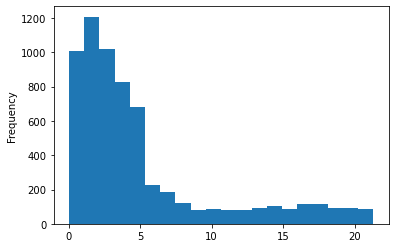

In [99]:
full['approvedyrs'] = (pd.to_datetime('now') - full['approved']) / np.timedelta64(1, 'Y')
full['approvedyrs'][full['approvedyrs'] > 0].plot.hist(bins=20)

In [100]:
full['approved1'] = full['approvedyrs'] < 1
full['approved2'] = full['approvedyrs'] < 2
full['approved5'] = full['approvedyrs'] < 5
full.drop(columns=['approved', 'approvedyrs'], inplace=True)

In [140]:
geometry = gpd.points_from_xy(full['longitude'], full['latitude'], crs='EPSG:4326')
points = gpd.GeoDataFrame(full, geometry=geometry).to_crs('EPSG:2263') #NYC equal area projection (ft)
points = points[~points['bin'].duplicated()]

buffer = points.copy() # each buffer refers to a BIN, aggregate on buffer BIN not BINs of points in buffer
buffer['geometry'] = buffer['geometry'].buffer(2640) # half mile radius

points = points[['geometry']]

In [141]:
neighbor = gpd.sjoin(points, buffer[:100], op='within')
neighbor_buffer = neighbor.groupby('bin')[['some_solar', 'approved1', 'approved2', 'approved5']].sum()

In [142]:
neighbor_buffer.sort_values('some_solar', ascending=False).head()

,some_solar,approved1,approved2,approved5
bin,,,,
1290422.0,214,53,80,197
3000108.0,3,1,1,1
3000106.0,3,1,1,1
3000104.0,3,1,1,1
3000103.0,3,1,1,1


<AxesSubplot:>

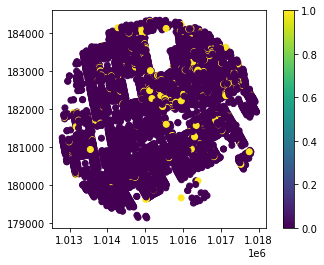

In [153]:
neighbor[(neighbor['bin'] == 1290422)].plot(column='some_solar', legend=True)

In [154]:
full[full['bin'] == 1290422]

,bin,shape_area,svf,latitude,longitude,numbldgs,yearbuilt,assesstot,exempttot,numfloors,...,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,approved1,approved2,approved5,geometry
0,1290422.0,1393.438325,0.684443,40.665415,-73.888027,1.0,2016.0,385650.0,383877.0,4.0,...,0,0,0,0,0,0,False,False,False,POINT (-73.88803 40.66542)
